In [1]:
import sys
import re
import os
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from Bio.Seq import Seq
import gget
import mappy as mp


In [2]:
n_sample = 75
n_rows = 2500
root_dir = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/fastq/p2/"

res = []

def read_fastq(fpath, n_rows):
    """a function to parse a fastq file """
    count = -1
    res = []
    for read in pysam.FastxFile(fpath):
        count += 1
        if count == n_rows:
            break

        NlaIII = read.sequence.count('CATG')
        quals = read.get_quality_array()
        row = {
            'read_name' : read.name,
            'seq_length' : len(read.sequence),
            'n_NlaIII' : NlaIII,
            'mean_base_quality' : np.mean(quals),
            'median_base_quality' : np.median(quals),
            'min_base_quality' : np.min(quals),
            'max_base_quality' : np.max(quals),
            'sequence' : read.sequence,
        }

        res.append(row)
    return pd.DataFrame(res)
    
res = []
for run in os.listdir(root_dir):

    subdir_path = f"{root_dir}{run}/merged_fastq/"
    sample_files = np.random.choice(os.listdir(subdir_path), n_sample)
    sample_files = [x for x in sample_files if not x == 'unclassified.fastq']

    for sample in sample_files:
        sample_path = f"{subdir_path}{sample}"

        bc_number = sample.replace("barcode", "").replace(".fastq", "")
        bc_id = f"BC{bc_number}"

        df = read_fastq(sample_path, n_rows)
        df['run'] = run
        df['barcode'] = bc_id
        res.append(df)

res = pd.concat(res)
print(f"{res.shape=}")
print(f"{res['read_name'].nunique()=}")
res.head()

res.shape=(557481, 10)
res['read_name'].nunique()=392481


,read_name,seq_length,n_NlaIII,mean_base_quality,median_base_quality,min_base_quality,max_base_quality,sequence,run,barcode
0,c0dfd14f-35e6-4d70-a0ca-3f39f2891012,965,5,16.602073,17.0,2,25,GTGTTATGTTGTTTCTTGGTTCGTTTACGTATTGCTGGTGCTGGAC...,scPC96o_3,BC64
1,f0940430-28dc-4c4a-925e-62ced217bf79,1623,7,16.889094,17.0,1,31,ATAACATTACTCGTTCAGTTACGTATTGCTGGTGCTGGACAGACAC...,scPC96o_3,BC64
2,b1c7cb31-e016-47ba-916c-fd08571d151a,271,0,25.011070,28.0,3,39,GTTATCCCTGTCTTGGTTCAGTTGGTCTTGCTGGTGCTGGACAGAC...,scPC96o_3,BC64
3,908654d7-e62b-48d1-9705-da448fa16b0d,1635,5,20.702752,21.0,2,44,ATGTTGTGGCCCCTTGGTTCAGTTACGTATTGCTGGTGCTGGACAG...,scPC96o_3,BC64
4,05d9cb57-1568-4c24-a74a-500d2aeeb756,1817,10,12.556962,13.0,2,30,TGTTGTGCGTGCTGGACTGGTTGGTGCTGGTGTTGGAGGCAGCCAT...,scPC96o_3,BC64


In [3]:
# load ont_barcodes
fpath = "../resources/ONT_barcode_96_sequences.csv"
df = pd.read_csv(fpath)
codes = dict(zip(df.Barcode.values, df.Sequence.values))
df.head()

,Barcode,Sequence,IDs
0,BC01,AAGAAAGTTGTCGGTGTCTTTGTG,BC01 / RB01
1,BC02,TCGATTCCGTTTGTAGTCGTCTGT,BC02 / RB02
2,BC03,GAGTCTTGTGTCCCAGTTACCAGG,BC03 / RB03
3,BC04,TTCGGATTCTATCGTGTTTCCCTA,BC04 / RB04
4,BC05,CTTGTCCAGGGTTTGTGTAACCTT,BC05 / RB05


In [4]:
# for _, record in res.sample(40).iterrows():
#     barcode = record['barcode']
#     read_name = record['read_name']
#     ont_seq = codes[barcode]
#     read_seq = record['sequence']
#     seq_len = record["seq_length"]
#     n_NlaIII = record["n_NlaIII"]

#     rev_comp = str(Seq(barcode).reverse_complement())

#     has_code = ont_seq in read_seq
#     has_code_rev = rev_comp in read_seq
#     print(f"{barcode=} {n_NlaIII=} {seq_len=} {has_code=}")

In [5]:
df = []

for _, record in res.iterrows():
    barcode = record['barcode']
    read_name = record['read_name']
    ont_seq = codes[barcode]
    read_seq = record['sequence']
    seq_len = record["seq_length"]
    n_NlaIII = record["n_NlaIII"]

    hits = read_seq.count(ont_seq)
    hits_rc = read_seq.count(str(Seq(ont_seq).reverse_complement()))

    row = {
        'run' : record['run'],
        'read_name' : read_name,
        'barcode' : barcode,
        'seq_len' : seq_len,
        'n_NlaIII' : n_NlaIII,
        'n_barcodes' : hits,
        'n_barcodes_rc' : hits_rc,
        'mean_base_quality' : record['mean_base_quality'],
    }

    df.append(row)

df  = pd.DataFrame(df)
df.head()


,run,read_name,barcode,seq_len,n_NlaIII,n_barcodes,n_barcodes_rc,mean_base_quality
0,scPC96o_3,c0dfd14f-35e6-4d70-a0ca-3f39f2891012,BC64,965,5,1,1,16.602073
1,scPC96o_3,f0940430-28dc-4c4a-925e-62ced217bf79,BC64,1623,7,1,1,16.889094
2,scPC96o_3,b1c7cb31-e016-47ba-916c-fd08571d151a,BC64,271,0,1,0,25.011070
3,scPC96o_3,908654d7-e62b-48d1-9705-da448fa16b0d,BC64,1635,5,1,0,20.702752
4,scPC96o_3,05d9cb57-1568-4c24-a74a-500d2aeeb756,BC64,1817,10,0,0,12.556962


# count NlaIII sites

In [6]:
df['ord'] = np.where(df['n_NlaIII'] == 0, 'none', 'higher')
df['ord'] = np.where(df['n_NlaIII'] == 1, 'pair', df['ord'] )
df['ord'].value_counts(normalize=True)

ord
higher    0.526818
none      0.370962
pair      0.102221
Name: proportion, dtype: float64

# count barcodes

In [7]:
df['cat'] = np.where(df['n_barcodes'] == 1, 'one', 'none')
df['cat'] = np.where(df['n_barcodes'] > 1, 'mulitple', df['cat'])

print(df.shape)
print(df['barcode'].nunique())
df['cat'].value_counts(normalize=True)

(557481, 10)
87


cat
one         0.541156
none        0.281611
mulitple    0.177233
Name: proportion, dtype: float64

In [8]:
df['cat_rc'] = np.where(df['n_barcodes_rc'] == 1, 'one', 'none')
df['cat_rc'] = np.where(df['n_barcodes_rc'] > 1, 'mulitple', df['cat_rc'])

print(df.shape)
print(df['barcode'].nunique())
df['cat_rc'].value_counts(normalize=True)

(557481, 11)
87


cat_rc
one         0.417101
none        0.410290
mulitple    0.172609
Name: proportion, dtype: float64

ord         higher      none      pair
cat                                   
mulitple  0.032055  0.119803  0.025375
none      0.150048  0.103060  0.028503
one       0.344715  0.148098  0.048342


<AxesSubplot: xlabel='ord', ylabel='cat'>

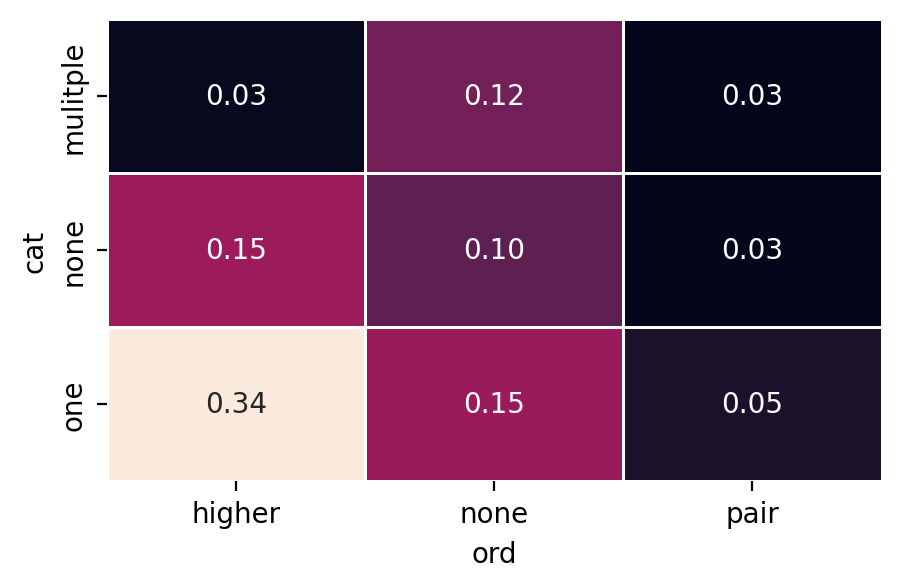

In [9]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat'], df['ord'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

ord         higher      none      pair
cat_rc                                
mulitple  0.034695  0.113918  0.023995
none      0.173920  0.186550  0.049821
one       0.318203  0.070494  0.028405


<AxesSubplot: xlabel='ord', ylabel='cat_rc'>

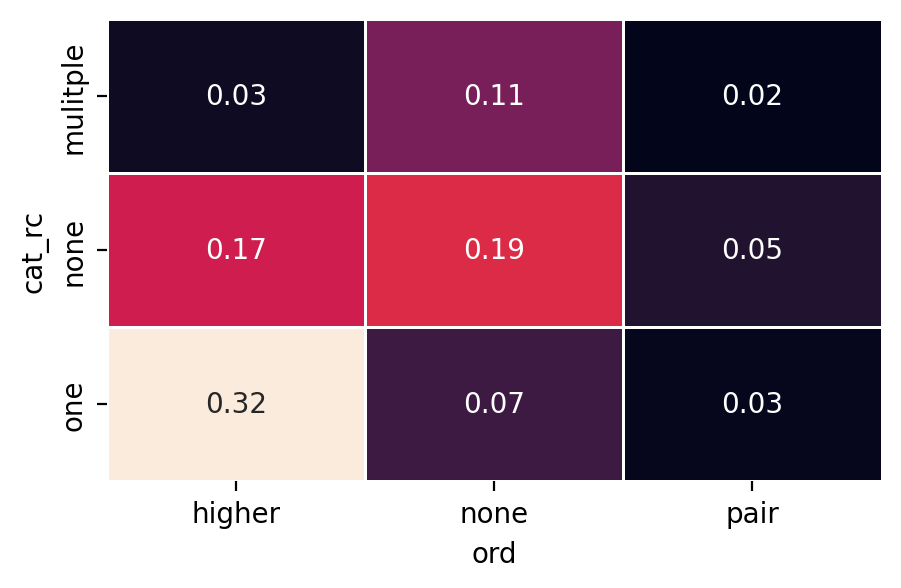

In [10]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat_rc'], df['ord'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

cat_rc    mulitple      none       one
cat                                   
mulitple  0.076885  0.063371  0.036977
none      0.050812  0.108856  0.121943
one       0.044911  0.238064  0.258181


<AxesSubplot: xlabel='cat_rc', ylabel='cat'>

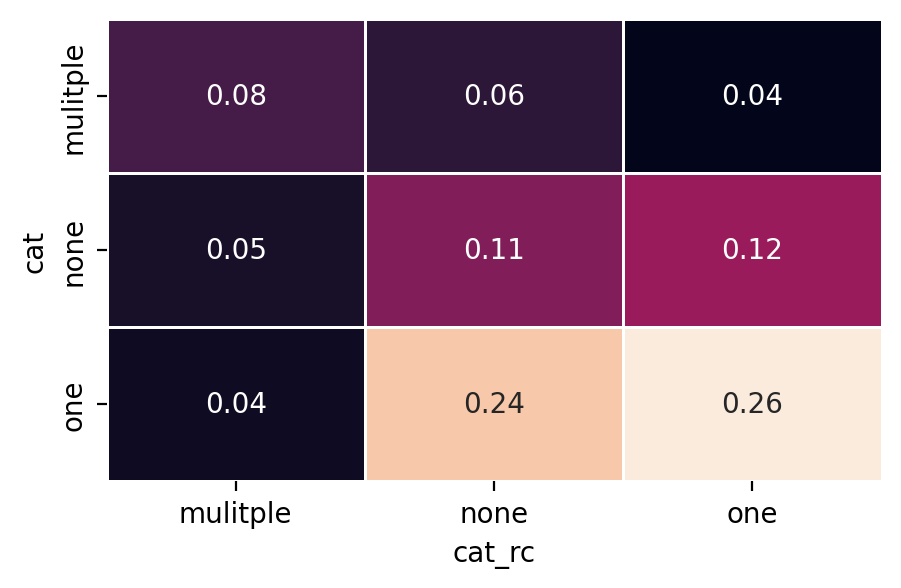

In [11]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat'], df['cat_rc'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

# number of reads with exactly one barcode (RC + forward)

In [12]:
test = df[df['n_barcodes'].isin([0, 1])]
test = test[test['n_barcodes_rc'].isin([0, 1])]

test = test[(test['n_barcodes'] != 0) & (test['n_barcodes_rc'] != 0)]

print(f"{test.shape=}")
print(test['ord'].value_counts(normalize=True))

test.head()

test.shape=(143931, 11)
ord
higher    0.870070
none      0.079809
pair      0.050121
Name: proportion, dtype: float64


,run,read_name,barcode,seq_len,n_NlaIII,n_barcodes,n_barcodes_rc,mean_base_quality,ord,cat,cat_rc
0,scPC96o_3,c0dfd14f-35e6-4d70-a0ca-3f39f2891012,BC64,965,5,1,1,16.602073,higher,one,one
1,scPC96o_3,f0940430-28dc-4c4a-925e-62ced217bf79,BC64,1623,7,1,1,16.889094,higher,one,one
7,scPC96o_3,615bc448-b52c-47d3-9377-405aa97eed7d,BC64,2113,8,1,1,17.140085,higher,one,one
9,scPC96o_3,9c907674-6760-4643-87e9-96fc0b2ffc83,BC64,1897,7,1,1,16.951502,higher,one,one
12,scPC96o_3,1744e709-247a-4363-b802-91cd42376574,BC64,2341,1,1,1,30.912003,pair,one,one


Thu Feb 29 12:30:40 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Thu Feb 29 12:30:40 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


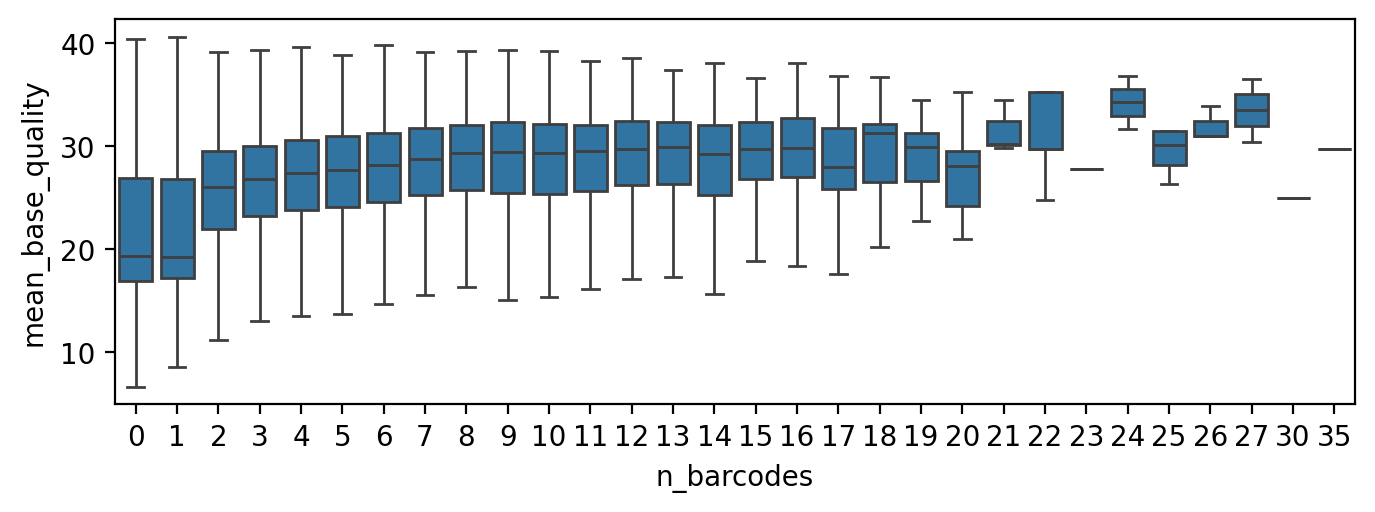

In [13]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='n_barcodes',
                y='mean_base_quality',
                showfliers=False)

plt.show()

Thu Feb 29 12:30:41 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Thu Feb 29 12:30:41 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


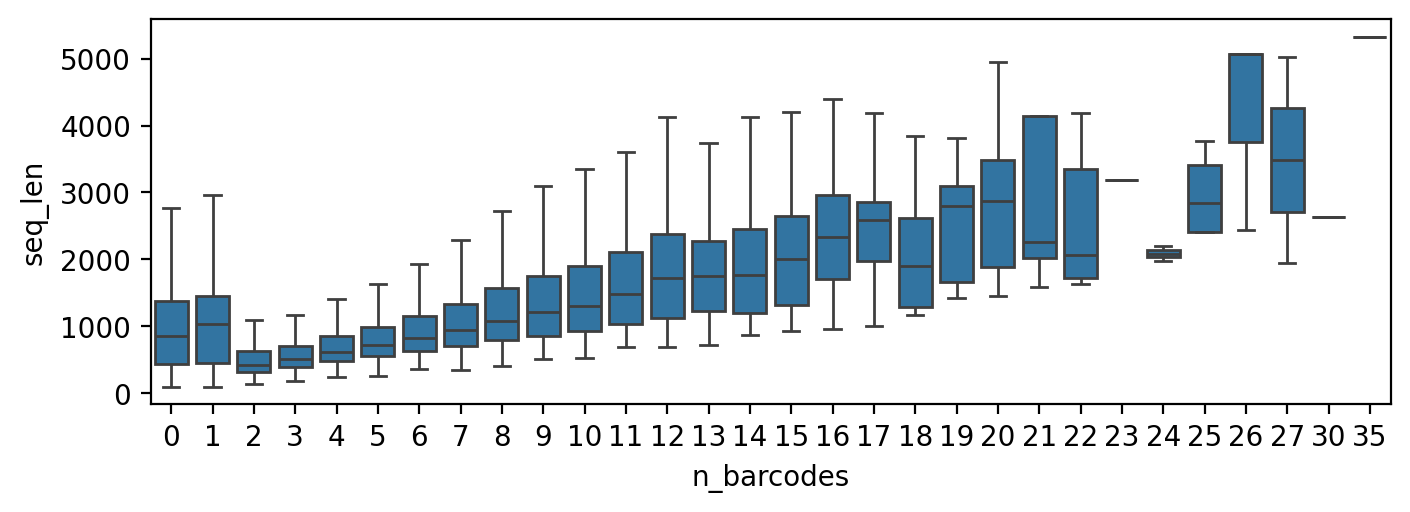

In [14]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='n_barcodes',
                y='seq_len',
                showfliers=False)
plt.show()

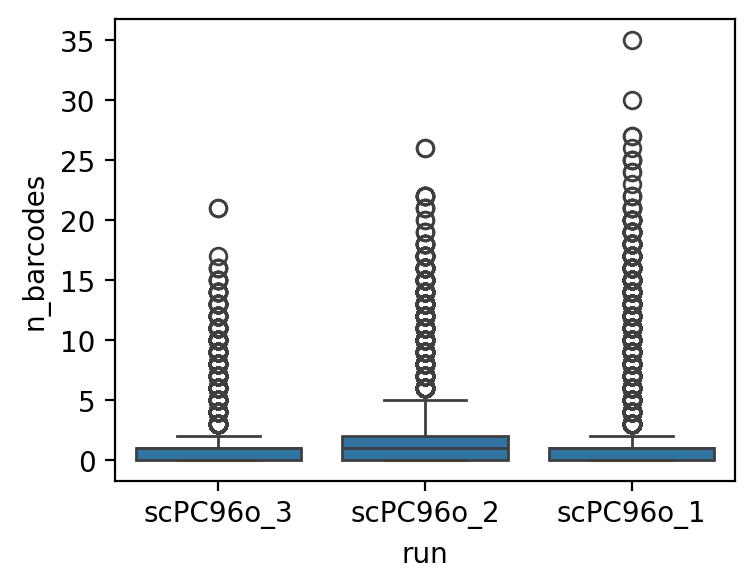

In [15]:
plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='run',
                y='n_barcodes')
plt.show()

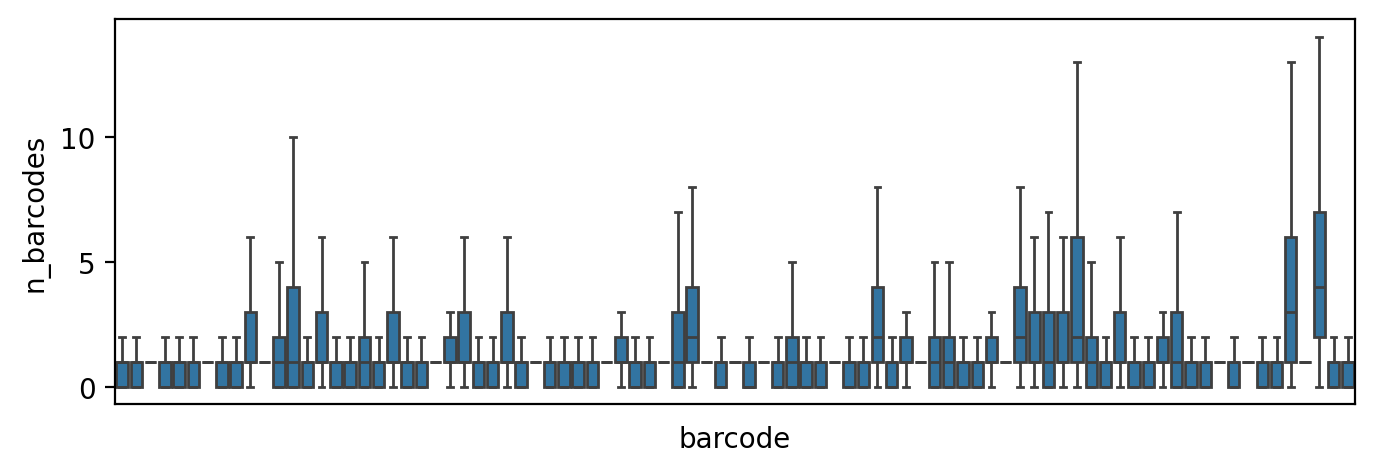

In [16]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df,
            x='barcode',
            y='n_barcodes',
            showfliers=False)

plt.xticks([])
plt.show()

# multiple barcodes

In [17]:
# let's look at a few extreme cases
barcodes = df[df['n_barcodes'] > 15]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]

for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()

=====  scPC96o_3 BC73  =====
READ NAME:  a7c5c19c-8711-4432-b996-405358789602
NUMBER NlaIII SITES:  0
ONT BARCODE:  AAGAAACAGGATGACAGAACCCTC
ONT BARCODE (RC):  GAGGGTTCTGTCATCCTGTTTCTT
READ SEQUENCE:  ATGTTTATGTGCAGCCCTTACTGGTTACAGTTACGTATTGTCTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGAAGATAGAGCGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTACTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCTCTTAACCTTTCTGTTGGTGCTGAAGAAACAGGATGACAGAACCCT

# Extactly one forward barcode

In [18]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()


=====  scPC96o_3 BC64  =====
READ NAME:  c0dfd14f-35e6-4d70-a0ca-3f39f2891012
NUMBER NlaIII SITES:  5
ONT BARCODE:  GACAGACACCGTTCATCGACTTTC
ONT BARCODE (RC):  GAAAGTCGATGAACGGTGTCTGTC
READ SEQUENCE:  GTGTTATGTTGTTTCTTGGTTCGTTTACGTATTGCTGGTGCTGGACAGACACCGTTCATCGACTTTCTTAACCTACTTGCCTGTCGCTCTATCTTCAGCATCTGCTTGGGTGTTTAACCTGTGCAGTGCTTTTACCAGCCTGAAAAGTAAACACAGTCTGTGTTTACTTCAAGGGGCAAGATCTCACCACACCTTATTGAAAATGGATCAGTGCAGGCCTGGCACAGACAGAGCACAGAGGGGTGAGAGCCAGCAAGGGAAGACAGGCCCACACCTCAGTACAGAGCCCAGGGGGAAGTCCTGGCTCTGGATCAATGCCCTGGGGGACATTCCTGGGGGGAAAGAATGAATTGCTATGCAAATGATCAATAAATAGCCATGCCACAATTTCATGCATAAGCCACCATATCCAGCCTACTAGTGTCTCTTGAGATGTCCATTACCAGAGACGTACACACCCCAGCATGTCAGAAGCCTCTGTGGTGTTGAGGGTTTTCTTTAAGGCTTAGACTCCTTGACCTAAAATAAACACTTGTGTCATACTGAGTGTAATGTTCTTGGTCTTGACTGGTTGACTATCAGTTCTGGATTAAGCTTCTCTTACCTATAAAACACTTATCATGTTTTTCATTGTAACTCATTGATATACACTGTTCTAGAAATCCCGTTTCCAACGAATGTGTTTTTCAGTGTAACTCACTCATCTAATATGTTCTACAGTGTGGTTTTTATCATTTTCCATGTACATAATTAATTTGTTTATTACCCCATTCTCTCTTACCCTTCTTTTCCTCTTTTC

In [19]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes_rc'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()

=====  scPC96o_3 BC64  =====
READ NAME:  c0dfd14f-35e6-4d70-a0ca-3f39f2891012
NUMBER NlaIII SITES:  5
ONT BARCODE:  GACAGACACCGTTCATCGACTTTC
ONT BARCODE (RC):  GAAAGTCGATGAACGGTGTCTGTC
READ SEQUENCE:  GTGTTATGTTGTTTCTTGGTTCGTTTACGTATTGCTGGTGCTGGACAGACACCGTTCATCGACTTTCTTAACCTACTTGCCTGTCGCTCTATCTTCAGCATCTGCTTGGGTGTTTAACCTGTGCAGTGCTTTTACCAGCCTGAAAAGTAAACACAGTCTGTGTTTACTTCAAGGGGCAAGATCTCACCACACCTTATTGAAAATGGATCAGTGCAGGCCTGGCACAGACAGAGCACAGAGGGGTGAGAGCCAGCAAGGGAAGACAGGCCCACACCTCAGTACAGAGCCCAGGGGGAAGTCCTGGCTCTGGATCAATGCCCTGGGGGACATTCCTGGGGGGAAAGAATGAATTGCTATGCAAATGATCAATAAATAGCCATGCCACAATTTCATGCATAAGCCACCATATCCAGCCTACTAGTGTCTCTTGAGATGTCCATTACCAGAGACGTACACACCCCAGCATGTCAGAAGCCTCTGTGGTGTTGAGGGTTTTCTTTAAGGCTTAGACTCCTTGACCTAAAATAAACACTTGTGTCATACTGAGTGTAATGTTCTTGGTCTTGACTGGTTGACTATCAGTTCTGGATTAAGCTTCTCTTACCTATAAAACACTTATCATGTTTTTCATTGTAACTCATTGATATACACTGTTCTAGAAATCCCGTTTCCAACGAATGTGTTTTTCAGTGTAACTCACTCATCTAATATGTTCTACAGTGTGGTTTTTATCATTTTCCATGTACATAATTAATTTGTTTATTACCCCATTCTCTCTTACCCTTCTTTTCCTCTTTTC

# No forward barcodes, reverse only

In [20]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes'] == 0) & (df['n_barcodes_rc'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()


=====  scPC96o_3 BC64  =====
READ NAME:  aca17321-c2e8-4eb5-ba76-03b1a75a0a23
NUMBER NlaIII SITES:  11
ONT BARCODE:  GACAGACACCGTTCATCGACTTTC
ONT BARCODE (RC):  GAAAGTCGATGAACGGTGTCTGTC
READ SEQUENCE:  ATGTCCTCTACTTGGTTCGGTTGCGTATTGCTGGTGCTGGACAGCACCGTTCATCGACTTTCTTAACCTACTTGCCTGTCGCTCTATCTTCGGCGTCTGCTTCGGTGTCTAACCTAAGCAGCTTGTTTTACAAATATTCCTTCTAAGCTGAATGTGGAAAATCATGCCCTTAAATCAACTTGGGTTAAGTATTAAGGGTTTATTTGGCTTACATGTGCCGTTGCAGAGTGGCACTGACTACTGCTGGCCACCACGCATAAGTTTGGACAAACAACCAATGTGTACATATGCAGTAAAGTTTTTTGCAAAGACACTGCCTGGCCCGGGCATGGACCTTACTCCAAAAGCCAATGAGCACAGCTAGAAAGGTTTTAAATACAAATCTCCAATTAAACAACAACAACAACAACAACAACAAAATAACCAGTGCTCCTTAAAGAAATAATGATTCCAAAGCTAGGACGAGCAAAGCACTTCCTGAGCCTCGCAAATGCTGGTCAGAGGGACATAGAAAAGCAACACGCTGGTGCTTCCCAATGGCTCCAGGGGAACTACGCTGACACTGCGCTACAAGTCATACTAAAGATGTACGTAAGTATGAGAAGAGAGAGCCCTTCCACCACATACCAAATTATTAAAAGTGAGAGAAACCATGGCTAGGGAAGTCAAAGGTCCTAGGAAAGAACCTATTGATTGATGTTTTCCTGACTGGTCATGAAAAATCCAAATTTAAGTTGCATTTATCTACAACTCCAGCCCTATAGAAGGTTCTGGAAGGAAAATTCAACCTGAAGATAG

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# look for all barcodes in a few sequences
for _, record in res.sample(100).iterrows():
    read_seq = record['sequence']
    barcode = record['barcode']
    for bc, ont_seq in codes.items():
        if ont_seq in read_seq:
            print(f"cell barcode: {barcode} found: {bc}")